## Welcome to Week 4, Day 4

This is the start of an AWESOME project! Really simple and very effective.

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool

from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv(override=True)

True

### Asynchronous LangGraph

To run a tool:  
Sync: `tool.run(inputs)`  
Async: `await tool.arun(inputs)`

To invoke the graph:  
Sync: `graph.invoke(state)`  
Async: `await graph.ainvoke(state)`

In [3]:
class State(TypedDict):
    
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

### Next: Install Playwright

On Windows and MacOS:  
`playwright install`

On Linux:  
`playwright install —with-reps chromium`

Student Mariano R. mentioned that you might also need to do this in a cursor terminal:

`uv run playwright install chromium`

In [5]:
!playwright install

## And now - after Installing Playwright, a heads up for Windows PC Users:

While executing the next few cells, you might hit a problem with the Playwright browser raising a NotImplementedError.

This should work when we move to python modules, but it can cause problems in Windows in a notebook.

If you it this error and would like to run the notebook, you need to make a small change which seems quite hacky! You need to do this AFTER installing Playwright (prior cells)

1. Right click in `.venv` in the File Explorer on the left and select "Find in folder"
2. Search for `asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())`  
3. That code should be found in a line of code in a file called `kernelapp.py`
4. Comment out the entire else clause that this line is a part of - see the fragment below. Be sure to have the "pass" statement after the ImportError line.
5. Restart the kernel by pressing the "Restart" button above

```python
        if sys.platform.startswith("win") and sys.version_info >= (3, 8):
            import asyncio
 
            try:
                from asyncio import WindowsProactorEventLoopPolicy, WindowsSelectorEventLoopPolicy
            except ImportError:
                pass
                # not affected
           # else:
            #    if type(asyncio.get_event_loop_policy()) is WindowsProactorEventLoopPolicy:
                    # WindowsProactorEventLoopPolicy is not compatible with tornado 6
                    # fallback to the pre-3.8 default of Selector
                    # asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())
```

Thank you to student Nicolas for finding this, and to Kalyan, Yaki, Zibin and Bhaskar for confirming that this worked for them! And to Vladislav for the extra pointers.

As an alternative, you can just move to a Python module (which we do anyway in Day 5)

In [6]:
# Introducing nest_asyncio
# Python async code only allows for one "event loop" processing aynchronous events.
# The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.

import nest_asyncio
nest_asyncio.apply()

### The LangChain community

One of the remarkable things about LangChain is the rich community around it.

Check this out:


In [7]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# If you get a NotImplementedError here or later, see the Heads Up at the top of the notebook

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [8]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
get_elements=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.c

In [9]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
await navigate_tool.arun({"url": "https://www.thehindu.com"})
text = await extract_text_tool.arun({})

In [10]:
import textwrap
print(textwrap.fill(text))

The Hindu: Latest News today from India and the World, Breaking news,
Top Headlines and Trending News Videos. | The Hindu July 31, 2025
e-Paper LOGIN Account eBooks Subscribe GIFT FRONT PAGE Search India
World Movies Sport Data Health Opinion Science Business Premium Live
Now News SECTION News India World States Cities TOPICS Ground Zero
Spotlight NEWSLETTER The View From India Looking at World Affairs from
the Indian perspective. SEE ALL NEWSLETTERS States Cities
Entertainment SECTION Entertainment Art Dance Movies Music Reviews
Theatre NEWSLETTER First Day First Show News and reviews from the
world of cinema and streaming. SEE ALL NEWSLETTERS Opinion SECTION
Opinion Editorial Cartoon Columns Comment Interview Lead Letters Open
Page Corrections & Clarifications Business SECTION Business Agri-
Business Economy Industry Markets Budget Sport SECTION Sport Cricket
Football Hockey Tennis Athletics Motorsport Races Other Sports TOPICS
Between Wickets Technology SECTION Technology Gadgets In

In [11]:
all_tools = tools + [tool_push]

In [12]:

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(all_tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


In [13]:
all_tools

[ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>),
 ExtractTextTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>),
 ExtractHyperlinksTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ksharma/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>),
 GetElementsTool(async_browser=<Browser type=<BrowserType name=chromium executable_path

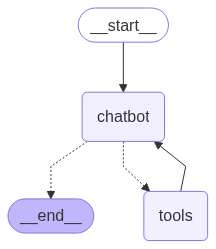

In [14]:

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "999"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()